# Import libraries

In [1]:
import random
import os
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Load the Dataset

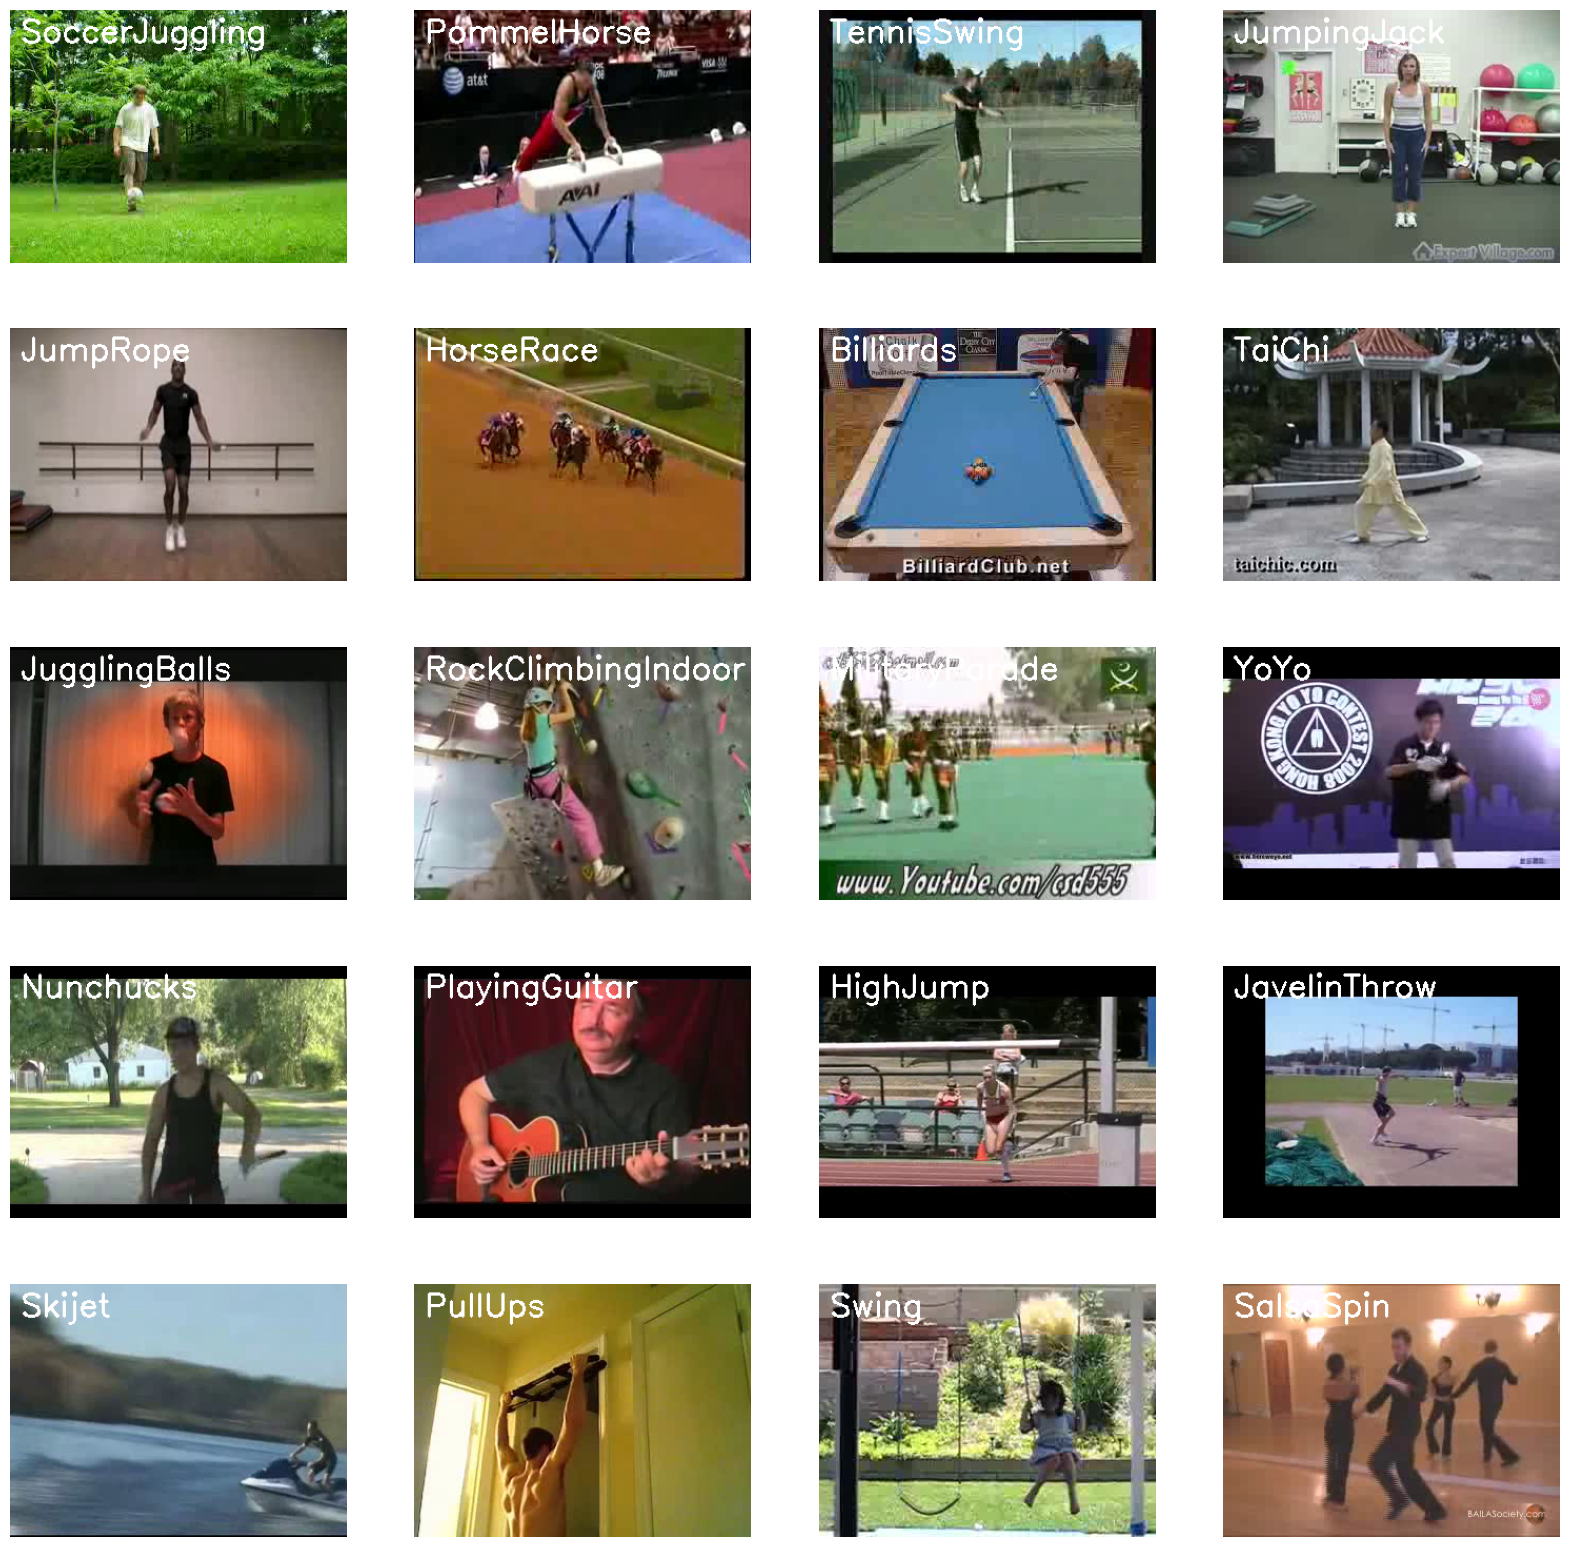

In [3]:
plt.figure(figsize=(20, 20))
classes = os.listdir("../data/")
random_values = random.sample(range(len(classes)), 20)

for counter, index in enumerate(random_values, 1):
    selected_class = classes[index]
    
    video_filenames = os.listdir(f"../data/{selected_class}")
    selected_video = random.choice(video_filenames)
    video_reader = cv2.VideoCapture(f"../data/{selected_class}/{selected_video}")
    _, bgr_frame = video_reader.read()
    video_reader.release()
    
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis("off")

# Data Preprocessing

In [4]:
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEQ_LENGTH = 20
DATASET_DIR = "../data"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [5]:
def frame_extraction(video_path):
    video_frames = []
    video_reader = cv2.VideoCapture(video_path)
    num_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    skip_frame_window = max(int(num_frames / SEQ_LENGTH), 1)
    for frame_counter in range(SEQ_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)
        success, frame = video_reader.read()
        
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        video_frames.append(normalized_frame)
        
    video_reader.release()
    return video_frames

In [6]:
def create_dataset():
    features, labels, video_file_paths = [], [], []

    for class_idx, class_name in enumerate(CLASSES_LIST):
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frame_extraction(video_file_path)
            
            if len(frames) == SEQ_LENGTH:
                features.append(frames)
                labels.append(class_idx)
                video_file_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_file_paths

In [7]:
features, labels, video_file_paths = create_dataset()

encoded_labels = to_categorical(labels)

# Train, test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.25, shuffle=True, random_state=SEQ_LENGTH)

# Model creation

In [8]:
def create_model():
    model = Sequential()
    
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQ_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))
    
    model.summary()
    
    return model

In [9]:
activity_recog_model = create_model()

d:\anaconda3\envs\my_env\AIML\Human-Activity-Recognition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
plot_model(activity_recog_model, to_file="activity_recognition.png", show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


# Model Fitting

In [12]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)

activity_recog_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

activity_recog_model.fit(x=X_train, y=y_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.2979 - loss: 1.3509 - val_accuracy: 0.3836 - val_loss: 1.3440
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.3767 - loss: 1.2666 - val_accuracy: 0.4795 - val_loss: 1.2226
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.4281 - loss: 1.1433 - val_accuracy: 0.4247 - val_loss: 1.1073
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.5856 - loss: 0.9616 - val_accuracy: 0.4521 - val_loss: 1.0313
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6712 - loss: 0.7692 - val_accuracy: 0.6164 - val_loss: 0.8481
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.7192 - loss: 0.6657 - val_accuracy: 0.7534 - val_loss: 0.6168
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 353ms/step - accuracy: 0.7568 - loss: 0.5189 - val_accuracy: 0.7260 - val_loss: 0.8369
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - accuracy: 0.8425 - loss: 0.3932 - val_accu